In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# to integrate the solver to network
class PyhsicalSolverLayer(torch.nn.Module):
    def __init__(self):
        super(PyhsicalSolverLayer, self).__init__()
    
    def forward(self,
                starting_points: torch.Tensor, 
                del_x: torch.Tensor, 
                force_vec: torch.Tensor):
        batch_size = starting_points.size(0) # deal with batch_size > 1
        num_steps = force_vec.size(1)
        traj = torch.zeros((batch_size, num_steps + 1 ,2))
        traj[:, 0,: ] = starting_points # set each of the batches
        for i in range(num_steps):
            traj[:, i + 1, 0] = traj[:, i, 0] + del_x.unsqueeze(0)
            traj[:, i + 1, 1] = traj[:, i, 1] + force_vec[:, i]
        return traj

In [3]:
class DiffPyhsicsModel(torch.nn.Module):
    def __init__(self):
        super(DiffPyhsicsModel, self).__init__()
        self.hidden_layer = torch.nn.Linear(1, 10)
        self.output_layer = torch.nn.Linear(10, 20)
        self.solver_layer = PyhsicalSolverLayer()

    def forward(self,  
                state0: torch.Tensor, 
                steps: int, 
                x_step: torch.Tensor):
        batch_size = state0.size(0)
        force = torch.reshape(state0[:, 1],(batch_size, 1))
        force = self.hidden_layer(force)
        force = torch.relu(force)
        force = self.output_layer(force) # output of network: force vector
        # call physical solver 
        traj = self.solver_layer(state0, x_step, force)
        return traj

In [5]:
class PyhsicalLoss(torch.nn.Module):
    def __init__(self):
        super(PyhsicalLoss, self).__init__()
    
    def potential(self, sequence : torch.Tensor):
        x2y2 = torch.square(sequence) # [x ^ 2, y ^ 2]
        x2y2_sum = torch.sum(x2y2, -1) # [x ^ 2 + y ^ 2]
        x2y2_subs = torch.sub(x2y2_sum, torch.Tensor([1.])) # [x ^ 2 + y ^ 2 -1]
        return torch.square(x2y2_subs)# [(x ^ 2 + y ^ 2 -1) ^ 2]
    
    def forward(self, sequence: torch.Tensor):
        potential_loss = self.potential(sequence)
        return torch.sum(potential_loss)

In [6]:
X_STEP = .1

In [7]:
starting_points = torch.zeros((100,2))
starting_points[:,0] = -1
r1 = -.01
r2 = .01
starting_points[:,1] = torch.rand(100) * (r2 - r1) - r2

In [8]:
solver_involved_network = DiffPyhsicsModel()
physical_loss = PyhsicalLoss()
optimizer_1 = torch.optim.Adam(solver_involved_network.parameters(), lr=1e-2)

In [9]:
# model_weights = solver_involved_network.state_dict()
# for name, weight in model_weights.items():
#     print(f"Parameter: {name}, Shape: {weight.shape}")
#     print(weight)

In [10]:
batch_size = 5

In [11]:
for i in range(1500):
    for j in range(0, len(starting_points), batch_size):
        traj_pred = solver_involved_network(starting_points[j:j+batch_size], 20, torch.tensor(X_STEP))
        loss = physical_loss(traj_pred)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
    if(i + 1) % 100 == 0:
        print(f"Epoch: {i + 1} loss: {loss}")

Epoch: 100 loss: 0.0015184017829596996
Epoch: 200 loss: 0.0004519923240877688
Epoch: 300 loss: 0.011825203895568848
Epoch: 400 loss: 0.000106347470136825
Epoch: 500 loss: 0.05506988614797592
Epoch: 600 loss: 0.0011420208029448986
Epoch: 700 loss: 0.0035523558035492897
Epoch: 800 loss: 0.0029998966492712498
Epoch: 900 loss: 0.0016903365030884743
Epoch: 1000 loss: 0.00179069465957582
Epoch: 1100 loss: 0.007093784864991903
Epoch: 1200 loss: 0.006053596269339323
Epoch: 1300 loss: 0.00010001278133131564
Epoch: 1400 loss: 1.7146230675280094e-06
Epoch: 1500 loss: 0.0009386375895701349


In [13]:
s0 = torch.tensor([[-1, 0.08]])
with torch.no_grad():
    predicted_traj = solver_involved_network(s0, 20, torch.tensor(0.1))

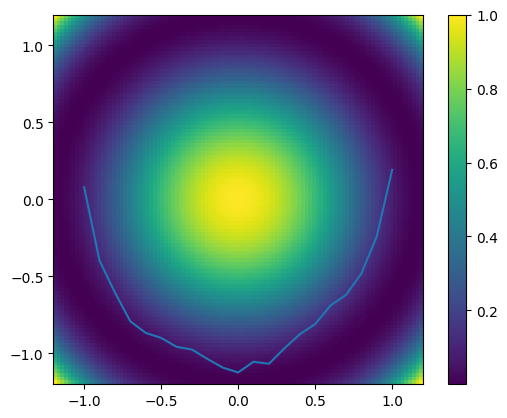

In [18]:
x,y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = (x ** 2 + y ** 2  - 1) ** 2
plt.imshow(z, extent = [-1.2, 1.2, -1.2, 1.2])
plt.plot(predicted_traj[:, :, 0][0], predicted_traj[:, :, 1][0])
plt.colorbar()

In [4]:
starting_points = torch.zeros((100,2))
starting_points[:,0] = -1
r1 = -.01
r2 = .01
starting_points[:,1] = torch.rand(100) * (r2 - r1) - r2

In [7]:
batch_size = starting_points.size(0)
del_x = torch.tensor(.1)
# num_steps = force_vec.size(1)
traj = torch.zeros((batch_size, 20 + 1, 2))
traj[:, 0] = starting_points

for i in range(20):
    traj[:, i + 1, 0] = traj[:, i, 0] + del_x.unsqueeze(0)
    traj[:, i + 1, 1] = traj[:, i, 1] + del_x.unsqueeze(0)

In [11]:
traj[:, 1, 0] = traj[:, i, 0] + del_x.unsqueeze(0)

In [13]:
traj

tensor([[[-1.0000e+00,  6.7848e-03],
         [ 1.0000e+00,  1.0678e-01],
         [-8.0000e-01,  2.0678e-01],
         ...,
         [ 8.0000e-01,  1.8068e+00],
         [ 9.0000e-01,  1.9068e+00],
         [ 1.0000e+00,  2.0068e+00]],

        [[-1.0000e+00,  4.5059e-04],
         [ 1.0000e+00,  1.0045e-01],
         [-8.0000e-01,  2.0045e-01],
         ...,
         [ 8.0000e-01,  1.8005e+00],
         [ 9.0000e-01,  1.9005e+00],
         [ 1.0000e+00,  2.0005e+00]],

        [[-1.0000e+00,  4.1140e-03],
         [ 1.0000e+00,  1.0411e-01],
         [-8.0000e-01,  2.0411e-01],
         ...,
         [ 8.0000e-01,  1.8041e+00],
         [ 9.0000e-01,  1.9041e+00],
         [ 1.0000e+00,  2.0041e+00]],

        ...,

        [[-1.0000e+00,  9.7874e-03],
         [ 1.0000e+00,  1.0979e-01],
         [-8.0000e-01,  2.0979e-01],
         ...,
         [ 8.0000e-01,  1.8098e+00],
         [ 9.0000e-01,  1.9098e+00],
         [ 1.0000e+00,  2.0098e+00]],

        [[-1.0000e+00,  9.4901e-03

In [16]:
starting_points.size(0)

100

In [10]:
traj = torch.zeros((100, 20 +1 ,2))
traj

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]])

In [13]:
traj.shape

torch.Size([100, 21, 2])

In [15]:
traj[:, 0,: ] = starting_points

In [16]:
traj

tensor([[[-1.0000, -0.0088],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.0000, -0.0089],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.0000,  0.0036],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        ...,

        [[-1.0000,  0.0013],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.0000, -0.0050],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.0000, -0.0059],
       

In [10]:
s0.size(0)

2

In [14]:
s0.size()

torch.Size([2])

In [15]:
s0.shape

torch.Size([2])

In [ ]:
#[5, 21, 2]

In [36]:
x = torch.tensor([[[1,2], [6,7], [11, 12]], [[3,4], [8,9], [10, 5]]])

In [40]:
x.shape

torch.Size([2, 3, 2])

In [37]:
x2y2 = torch.square(x) # [x ^ 2, y ^ 2]
x2y2

tensor([[[  1,   4],
         [ 36,  49],
         [121, 144]],

        [[  9,  16],
         [ 64,  81],
         [100,  25]]])

In [46]:
x2y2_sum = torch.sum(x2y2, -1) # [x ^ 2 + y ^ 2]
x2y2_sum

tensor([[  5,  85, 265],
        [ 25, 145, 125]])

In [47]:
x2y2_subs = torch.sub(x2y2_sum, torch.Tensor([1.])) # [x ^ 2 + y ^ 2 -1]
x2y2_subs

tensor([[  4.,  84., 264.],
        [ 24., 144., 124.]])

In [52]:
ss = torch.sum(x2y2_subs)# [(x ^ 2 + y ^ 2 -1) ^ 2]
ss

tensor(644.)

In [51]:
torch.sum(ss)

tensor(113456.)